## **Preparing data**

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

import nltk
import random
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

## Preprocess and tokenize text
def preprocess_and_tokenize(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    preprocessed_text = ' '.join(cleaned_tokens)  # For the preprocessed column
    return preprocessed_text, cleaned_tokens

##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=150):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_text = ' '.join(words[start_index:start_index + record_length])
        preprocessed_text, tokens = preprocess_and_tokenize(sample_text)

        samples.append({
            'Title': title,
            'Author': author,
            'Label': label,
            'Preprocessed_Text': preprocessed_text,
            'Tokens': tokens
        })

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/1342/pg1342-images.html",
             "https://www.gutenberg.org/cache/epub/2489/pg2489-images.html",
             "https://www.gutenberg.org/cache/epub/43/pg43-images.html",
             "https://www.gutenberg.org/cache/epub/174/pg174-images.html",
             "https://www.gutenberg.org/cache/epub/1661/pg1661-images.html",
             "https://www.gutenberg.org/cache/epub/36/pg36-images.html"]
df = create_dataframe(book_urls)



df


,Title,Author,Label,Preprocessed_Text,Tokens
0,Pride and Prejudice,Jane Austen,a,say p peopl much said lucki p ye sir know go w...,"[say, p, peopl, much, said, lucki, p, ye, sir,..."
1,Pride and Prejudice,Jane Austen,a,div figcent width figur img imag unavail div c...,"[div, figcent, width, figur, img, imag, unavai..."
2,Pride and Prejudice,Jane Austen,a,result previou studi thing give miss austen re...,"[result, previou, studi, thing, give, miss, au..."
3,Pride and Prejudice,Jane Austen,a,tongu servant wait tabl judg better one househ...,"[tongu, servant, wait, tabl, judg, better, one..."
4,Pride and Prejudice,Jane Austen,a,near relat patro happen overhear gentleman men...,"[near, relat, patro, happen, overhear, gentlem..."
...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot glass overturn water trough movement langu...,"[lot, glass, overturn, water, trough, movement..."
1196,The War of the Worlds,H. G. Wells,f,see look detail clear peopl hous better go alo...,"[see, look, detail, clear, peopl, hous, better..."
1197,The War of the Worlds,H. G. Wells,f,strike breviti p martian alarm approach crowd ...,"[strike, breviti, p, martian, alarm, approach,..."
1198,The War of the Worlds,H. G. Wells,f,brute said good god ugli brute repeat p see ma...,"[brute, said, good, god, ugli, brute, repeat, ..."


In [ ]:
import pandas as pd

# Assuming `df` is your DataFrame created from `create_dataframe` function
# Example dictionary, replace 'Author A', 'Author B', etc., with actual author names and their genres
author_to_genre = {
    'Jane Austen': 'Classic Romance',
    'Herman Melville': 'Adventure/Sea Story',
    'Robert Louis Stevenson': 'Psychological Thriller/Mystery',
    'Oscar Wilde': 'Philosophical Fiction',
    'Arthur Conan Doyle': 'Mystery/Detective Fiction',
    'H. G. Wells': 'Science Fiction'

    # Add more mappings as needed
}

# Function to map each author to a genre
def map_genre(author):
    return author_to_genre.get(author, 'Unknown')  # Default genre if author not found

# Apply the function to create a new 'Genre' column based on 'Author' column
df['Genre'] = df['Author'].apply(map_genre)

df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre
0,Pride and Prejudice,Jane Austen,a,say p peopl much said lucki p ye sir know go w...,"[say, p, peopl, much, said, lucki, p, ye, sir,...",Classic Romance
1,Pride and Prejudice,Jane Austen,a,div figcent width figur img imag unavail div c...,"[div, figcent, width, figur, img, imag, unavai...",Classic Romance
2,Pride and Prejudice,Jane Austen,a,result previou studi thing give miss austen re...,"[result, previou, studi, thing, give, miss, au...",Classic Romance
3,Pride and Prejudice,Jane Austen,a,tongu servant wait tabl judg better one househ...,"[tongu, servant, wait, tabl, judg, better, one...",Classic Romance
4,Pride and Prejudice,Jane Austen,a,near relat patro happen overhear gentleman men...,"[near, relat, patro, happen, overhear, gentlem...",Classic Romance
...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot glass overturn water trough movement langu...,"[lot, glass, overturn, water, trough, movement...",Science Fiction
1196,The War of the Worlds,H. G. Wells,f,see look detail clear peopl hous better go alo...,"[see, look, detail, clear, peopl, hous, better...",Science Fiction
1197,The War of the Worlds,H. G. Wells,f,strike breviti p martian alarm approach crowd ...,"[strike, breviti, p, martian, alarm, approach,...",Science Fiction
1198,The War of the Worlds,H. G. Wells,f,brute said good god ugli brute repeat p see ma...,"[brute, said, good, god, ugli, brute, repeat, ...",Science Fiction


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert the list of tokens back to string format
df['Text_for_BOW'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Apply the vectorizer on the preprocessed text
X_bow = vectorizer.fit_transform(df['Text_for_BOW'])

# Optionally, convert to DataFrame (if you want to see the matrix or work with it directly)
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Add a column to your original df indicating the number of unique words in each sample
df['Unique_Word_Count'] = df['Tokens'].apply(lambda x: len(set(x)))


In [ ]:
df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,Text_for_BOW,Unique_Word_Count
0,Pride and Prejudice,Jane Austen,a,say p peopl much said lucki p ye sir know go w...,"[say, p, peopl, much, said, lucki, p, ye, sir,...",Classic Romance,say p peopl much said lucki p ye sir know go w...,48
1,Pride and Prejudice,Jane Austen,a,div figcent width figur img imag unavail div c...,"[div, figcent, width, figur, img, imag, unavai...",Classic Romance,div figcent width figur img imag unavail div c...,63
2,Pride and Prejudice,Jane Austen,a,result previou studi thing give miss austen re...,"[result, previou, studi, thing, give, miss, au...",Classic Romance,result previou studi thing give miss austen re...,64
3,Pride and Prejudice,Jane Austen,a,tongu servant wait tabl judg better one househ...,"[tongu, servant, wait, tabl, judg, better, one...",Classic Romance,tongu servant wait tabl judg better one househ...,56
4,Pride and Prejudice,Jane Austen,a,near relat patro happen overhear gentleman men...,"[near, relat, patro, happen, overhear, gentlem...",Classic Romance,near relat patro happen overhear gentleman men...,53
...,...,...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot glass overturn water trough movement langu...,"[lot, glass, overturn, water, trough, movement...",Science Fiction,lot glass overturn water trough movement langu...,64
1196,The War of the Worlds,H. G. Wells,f,see look detail clear peopl hous better go alo...,"[see, look, detail, clear, peopl, hous, better...",Science Fiction,see look detail clear peopl hous better go alo...,58
1197,The War of the Worlds,H. G. Wells,f,strike breviti p martian alarm approach crowd ...,"[strike, breviti, p, martian, alarm, approach,...",Science Fiction,strike breviti p martian alarm approach crowd ...,63
1198,The War of the Worlds,H. G. Wells,f,brute said good god ugli brute repeat p see ma...,"[brute, said, good, god, ugli, brute, repeat, ...",Science Fiction,brute said good god ugli brute repeat p see ma...,60


In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
import numpy as np

In [ ]:
# Directly use X_bow for clustering
X = X_bow  # This is your BOW feature matrix

# Number of clusters - adjust based on your specific needs or domain knowledge
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['KMeans_Clusters_BOW'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


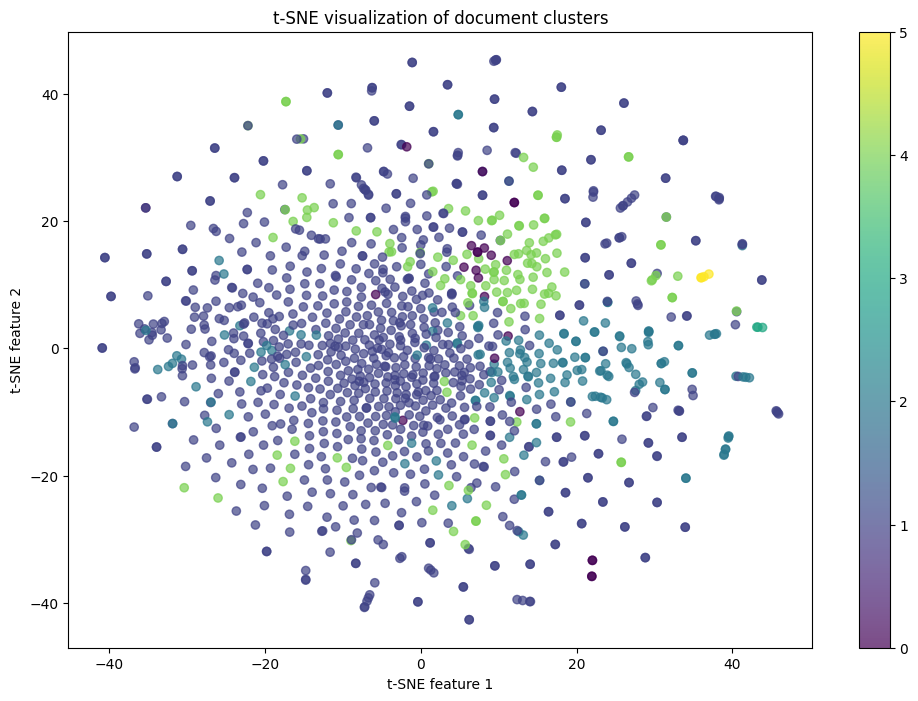

In [ ]:
from sklearn.manifold import TSNE

# Configure t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Apply t-SNE to document vectors (this may take some time depending on the dataset size)
X_tsne = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense
import matplotlib.pyplot as plt

# Assume 'kmeans_labels' are the cluster labels from the K-means clustering step
# Plot t-SNE 2D projection with cluster labels
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o', alpha=0.7)

# Optionally add cluster centroids if it's meaningful in the t-SNE space (usually not for t-SNE)
# centroids = kmeans.cluster_centers_
# centroids_tsne = tsne.fit_transform(centroids)
# plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], c='red', marker='x')

plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of document clusters')
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture

# Optimal number of clusters from the silhouette analysis
optimal_clusters = 6

# Initialize and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels= gmm.fit_predict(X.toarray())  # For GMM, convert sparse to dense
df['GMM_Clusters_BOW'] = gmm_labels


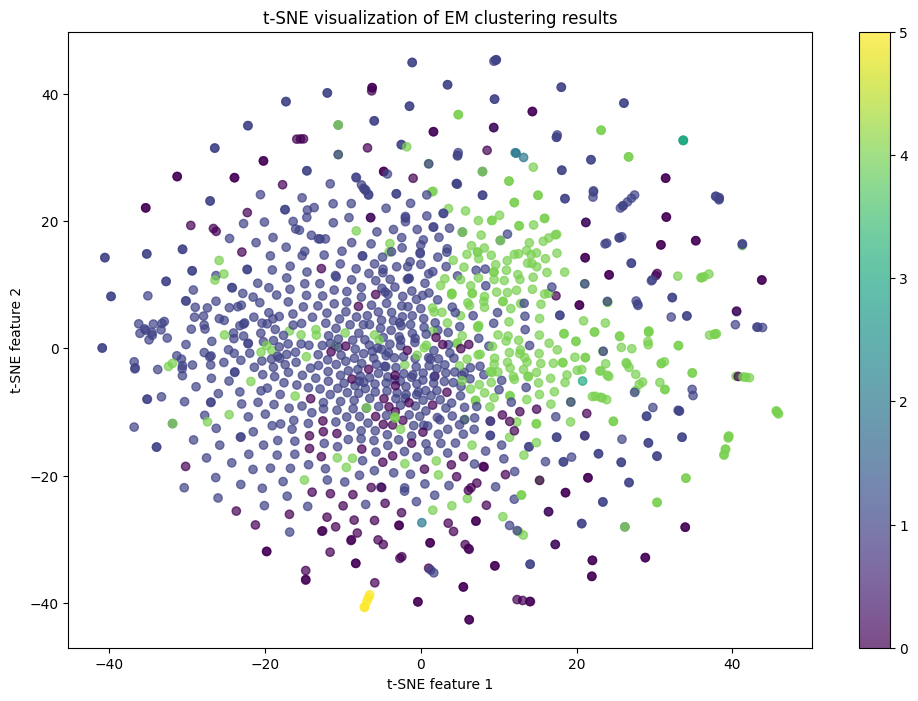

In [ ]:
#Visualizations
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of EM clustering results')
plt.show()

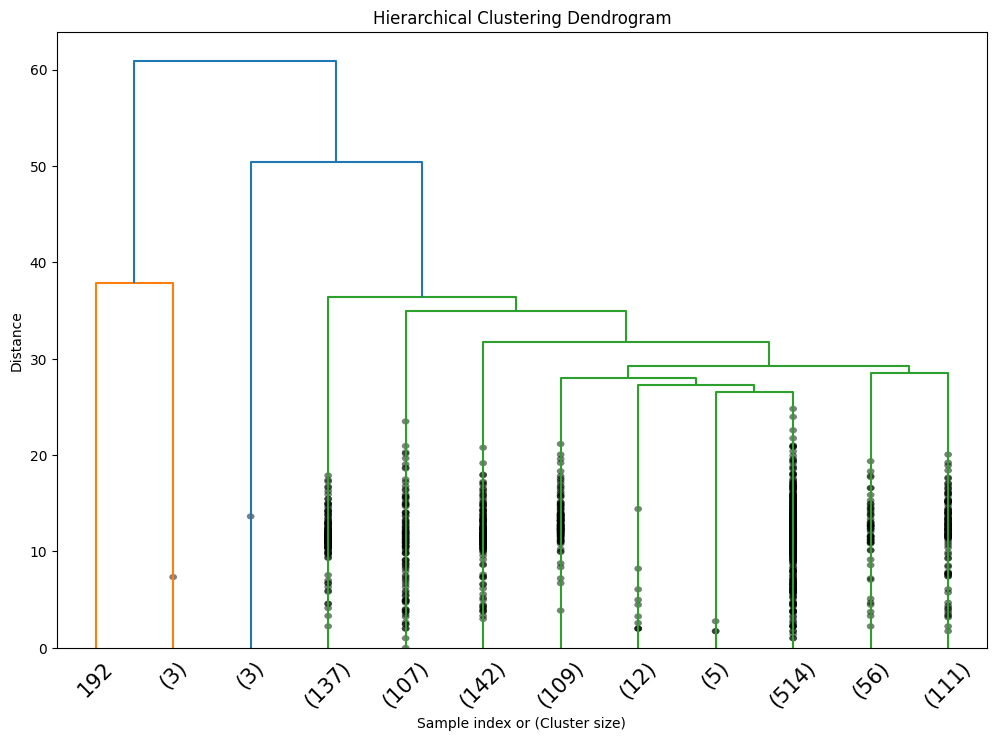

In [ ]:
# Hierarchical Clustering
linkage_matrix = linkage(X.toarray(), 'ward')  # Convert sparse to dense for hierarchical clustering

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()

Text(0.5, 1.0, 't-SNE visualization of Hierarchical clustering results')

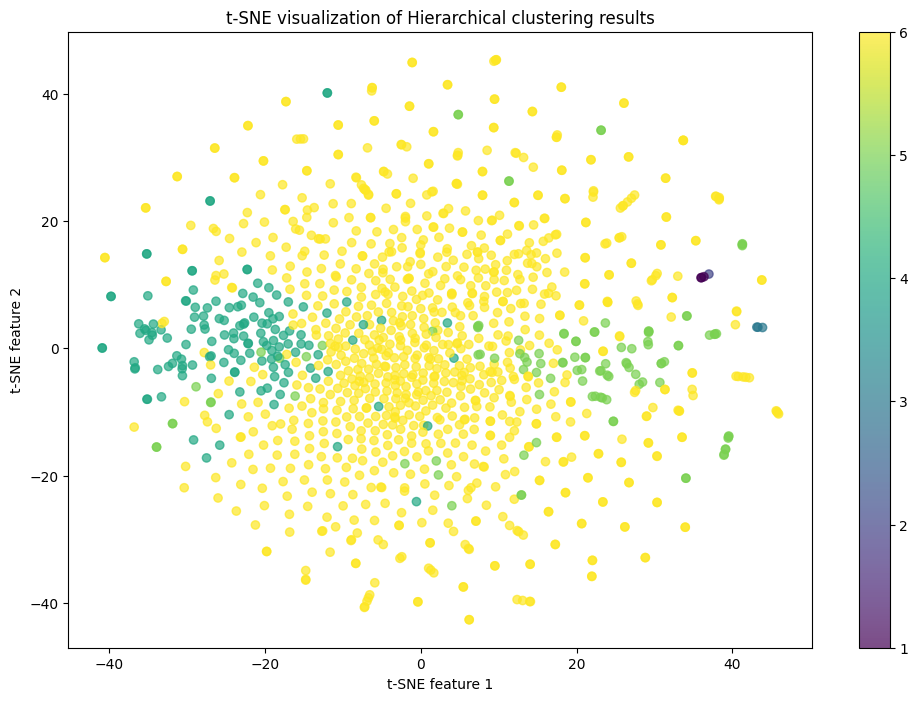

In [ ]:
# Flatten the dendrogram to get cluster labels
hierarchical_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
df['Hierarchical_Clusters_BOW'] = hierarchical_labels

# Hierarchical t-SNE Plot
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of Hierarchical clustering results')

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

def calculate_kappa(true_labels_encoded, cluster_labels):
    """
    Calculates Cohen's Kappa Score comparing true labels and clustering labels.

    Parameters:
    - true_labels_encoded: Encoded true labels (e.g., obtained using LabelEncoder).
    - cluster_labels: Cluster labels obtained from clustering algorithms.

    Returns:
    - kappa_score: Cohen's Kappa Score.
    """
    kappa_score = cohen_kappa_score(true_labels_encoded, cluster_labels)
    return kappa_score

# Corrected Kappa Scores calculation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

kappa_kmeans = calculate_kappa(true_labels_encoded, df['KMeans_Clusters_BOW'])
print(f"Cohen's Kappa Score (K-means with BOW): {kappa_kmeans}")

# Ensure the DataFrame contains the GMM labels
df['GMM_Clusters'] = gmm_labels  # Add this line if it's missing
kappa_gmm = calculate_kappa(true_labels_encoded, df['GMM_Clusters_BOW'])
print(f"Cohen's Kappa Score (GMM with BOW): {kappa_gmm}")

# Add hierarchical clustering labels to the DataFrame
df['Hierarchical_Clusters'] = hierarchical_labels
kappa_hierarchical = calculate_kappa(true_labels_encoded, df['Hierarchical_Clusters_BOW'])
print(f"Cohen's Kappa Score (Hierarchical with BOW): {kappa_hierarchical}")

Cohen's Kappa Score (K-means with BOW): 0.06799999999999995
Cohen's Kappa Score (GMM with BOW): -0.04699999999999971
Cohen's Kappa Score (Hierarchical with BOW): 0.02432004604979121


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for K-means
silhouette_kmeans = silhouette_score(X, kmeans_labels)
print(f"Silhouette Score (K-means with BOW): {silhouette_kmeans}")

# Calculate Silhouette Score for GMM
silhouette_gmm = silhouette_score(X, gmm_labels)
print(f"Silhouette Score (GMM  with BOW): {silhouette_gmm}")

# Calculate Silhouette Score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
print(f"Silhouette Score (Hierarchical  with BOW): {silhouette_hierarchical}")

Silhouette Score (K-means with BOW): 0.0037189655788665023
Silhouette Score (GMM  with BOW): -0.012354624513572728
Silhouette Score (Hierarchical  with BOW): -0.0005783229545898035


In [ ]:
# Modified function to work with BOW features
def extract_top_words_bow(X_bow, cluster_labels, feature_names, n_top_words=10):
    top_words_by_cluster = []
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_bow = X_bow[cluster_indices]
        word_sums = np.array(cluster_bow.sum(axis=0)).flatten()  # Sum word counts across all documents in the cluster
        top_word_indices = word_sums.argsort()[-n_top_words:][::-1]  # Get indices of top words
        top_words = [feature_names[i] for i in top_word_indices]
        top_words_by_cluster.append(top_words)
    return top_words_by_cluster

# Assuming cluster labels are stored in these columns
kmeans_labels = df['KMeans_Clusters_BOW']
gmm_labels = df['GMM_Clusters_BOW']
hierarchical_labels = df['Hierarchical_Clusters_BOW']

# Extract feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract top words for each cluster
top_words_by_cluster_kmeans = extract_top_words_bow(X_bow, kmeans_labels, feature_names)
top_words_by_cluster_gmm = extract_top_words_bow(X_bow, gmm_labels, feature_names)
top_words_by_cluster_hierarchical = extract_top_words_bow(X_bow, hierarchical_labels, feature_names)

print("Top words by cluster (KMeans with BOW):", top_words_by_cluster_kmeans)
print("Top words by cluster (GMM with BOW):", top_words_by_cluster_gmm)
print("Top words by cluster (Hierarchical with BOW):", top_words_by_cluster_hierarchical)

Top words by cluster (KMeans with BOW): [['one', 'said', 'basil', 'us', 'know', 'peopl', 'look', 'want', 'dorian', 'never'], ['one', 'would', 'upon', 'could', 'man', 'time', 'seem', 'like', 'littl', 'look'], ['said', 'utterson', 'sir', 'one', 'look', 'like', 'man', 'see', 'lawyer', 'could'], ['br', 'memori', 'whale', 'aye', 'sacr', 'captain', 'hand', 'boat', 'follow', 'one'], ['one', 'chapter', 'dorian', 'henri', 'look', 'lord', 'said', 'like', 'end', 'would'], ['pgintern', 'tr', 'td', 'br', 'incid', 'jekyl', 'case', 'door', 'lanyon', 'dr']]
Top words by cluster (GMM with BOW): [['came', 'one', 'peopl', 'martian', 'like', 'seem', 'black', 'toward', 'saw', 'side'], ['one', 'would', 'could', 'upon', 'man', 'time', 'seem', 'much', 'whale', 'like'], ['made', 'man', 'natur', 'fault', 'life', 'mani', 'high', 'sens', 'even', 'reach'], ['wind', 'pool', 'wish', 'never', 'along', 'pavement', 'pull', 'middl', 'spite', 'lash'], ['said', 'one', 'look', 'like', 'dorian', 'man', 'utterson', 'know', '

In [ ]:
def calculate_bow_coherence(top_words_by_cluster, X_bow, vectorizer, df, cluster_column):
    feature_names = vectorizer.get_feature_names_out()
    word_to_index = {word: index for index, word in enumerate(feature_names)}
    coherence_scores = []
    for cluster in df[cluster_column].unique():
        word_indices = [word_to_index[word] for top_words in top_words_by_cluster for word in top_words if word in word_to_index]
        # Only consider documents in the current cluster
        cluster_bow = X_bow[df[cluster_column] == cluster]
        co_occurrence_sum = 0
        possible_pairs = 0
        for i in range(len(word_indices)):
            for j in range(i + 1, len(word_indices)):
                word_i = word_indices[i]
                word_j = word_indices[j]
                # Ensure you're only using the BOW matrix for these words if they're present
                if word_i < X_bow.shape[1] and word_j < X_bow.shape[1]:
                    co_occurrence = ((cluster_bow[:, word_i].toarray() > 0) & (cluster_bow[:, word_j].toarray() > 0)).sum()
                    co_occurrence_sum += co_occurrence
                    possible_pairs += 1
        cluster_coherence = co_occurrence_sum / possible_pairs if possible_pairs > 0 else 0
        coherence_scores.append(cluster_coherence)
    overall_coherence = np.mean(coherence_scores) if coherence_scores else 0
    return overall_coherence
# Example usage:
coherence_kmeans = calculate_bow_coherence(top_words_by_cluster_kmeans, X_bow, vectorizer, df, 'KMeans_Clusters_BOW')
coherence_gmm = calculate_bow_coherence(top_words_by_cluster_gmm, X_bow, vectorizer, df, 'GMM_Clusters_BOW')
coherence_hierarchical = calculate_bow_coherence(top_words_by_cluster_hierarchical, X_bow, vectorizer, df, 'Hierarchical_Clusters_BOW')
print(f"Coherence (K-means with BOW): {coherence_kmeans}")
print(f"Coherence (GMM with BOW): {coherence_gmm}")
print(f"Coherence (Hierarchical with BOW): {coherence_hierarchical}")

Coherence (K-means with BOW): 5.913088512241054
Coherence (GMM with BOW): 3.8257062146892657
Coherence (Hierarchical with BOW): 3.471845574387947


#Error Analysis BOW


In [ ]:
!pip install wordcloud matplotlib

Cluster 0 Top Words Visualization


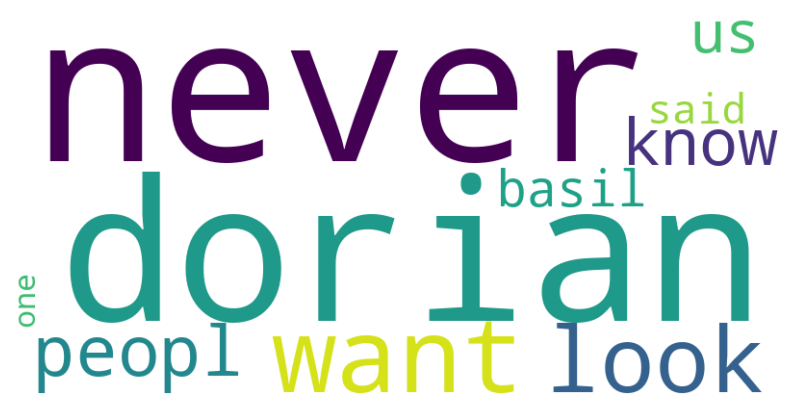

Cluster 1 Top Words Visualization


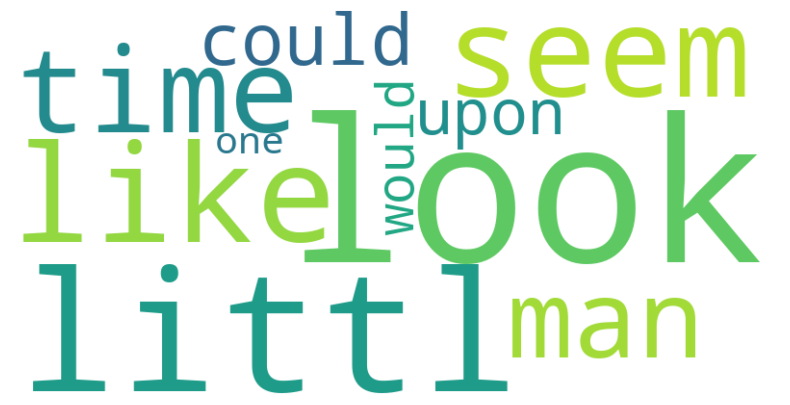

Cluster 2 Top Words Visualization


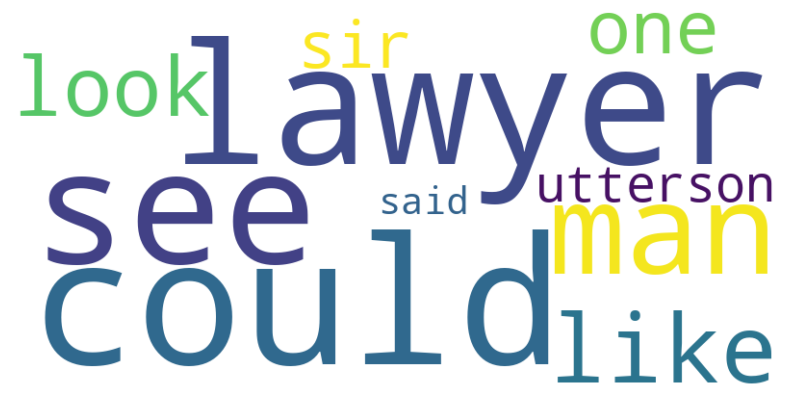

Cluster 3 Top Words Visualization


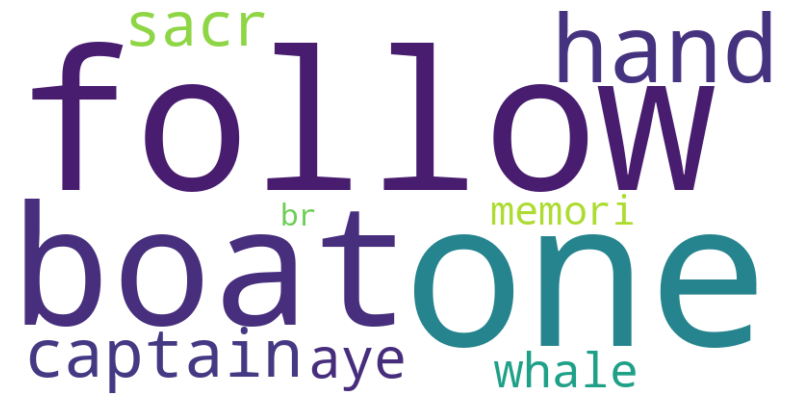

Cluster 4 Top Words Visualization


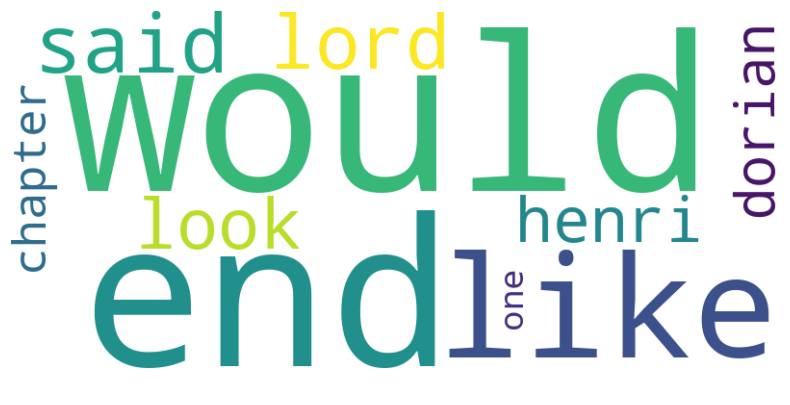

Cluster 5 Top Words Visualization


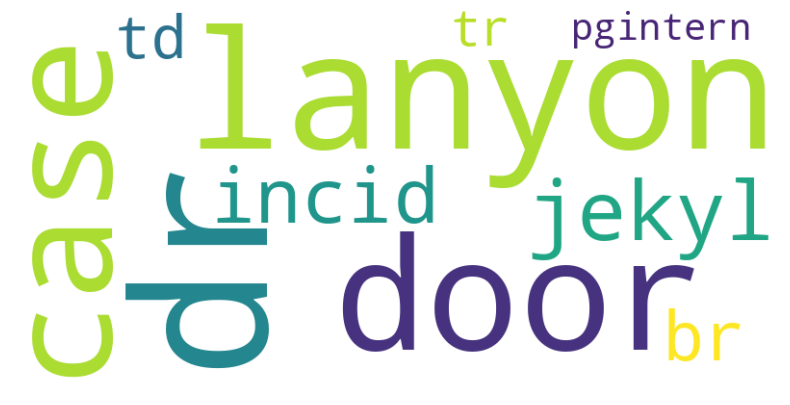

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_top_words(top_words_list):
    """
    Generates a word cloud from a list of top words.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_list)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Assuming `top_words_by_cluster_kmeans` is a list of lists of top words for each cluster
for cluster_id, top_words in enumerate(top_words_by_cluster_kmeans):
    # Assigning equal frequency for simplicity, you can adjust this based on your requirement
    top_words_freq = {word: idx + 1 for idx, word in enumerate(top_words)}
    print(f"Cluster {cluster_id} Top Words Visualization")
    visualize_top_words(top_words_freq)


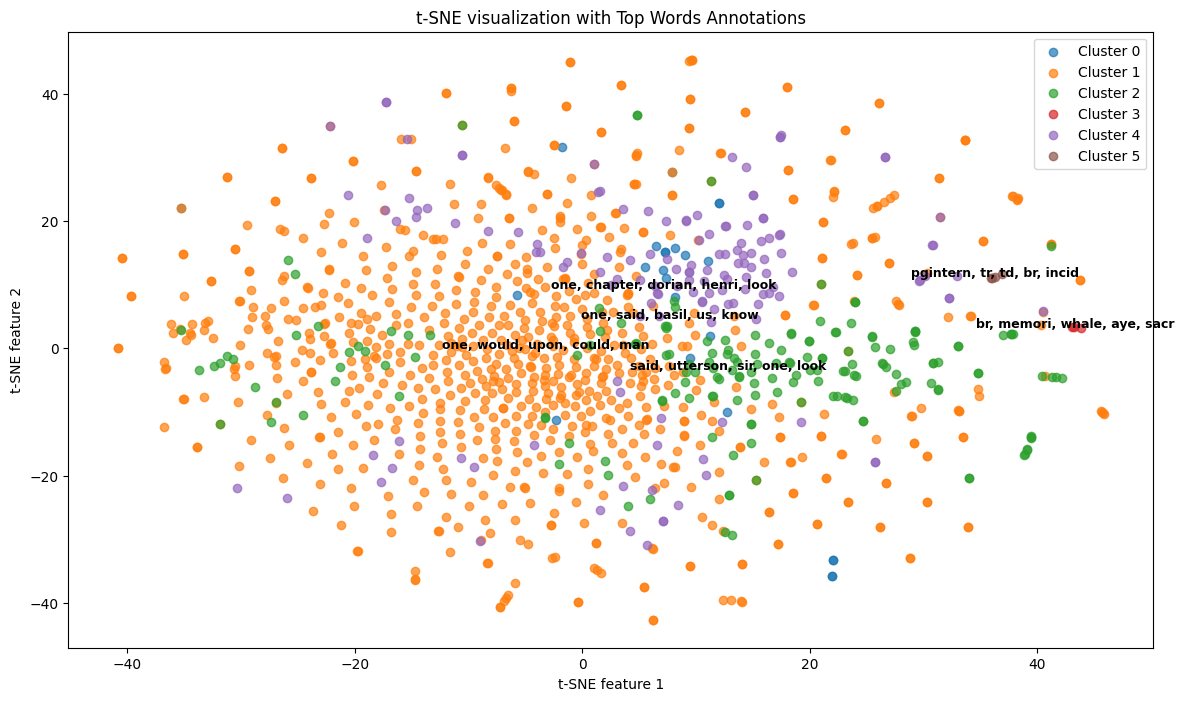

In [ ]:
def plot_tsne_with_annotations(X_tsne, labels, df, cluster_column, top_words_by_cluster):
    """
    Plots t-SNE reduced features with annotations for each cluster's top words.
    """
    plt.figure(figsize=(14, 8))
    unique_labels = sorted(set(labels))
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Cluster {label}', alpha=0.7)
        # Annotate cluster centers with top words
        cluster_center = np.mean(X_tsne[indices, :], axis=0)
        top_words = ', '.join(top_words_by_cluster[label][:5])  # Top 5 words
        plt.text(cluster_center[0], cluster_center[1], top_words, fontsize=9, weight='bold', ha='center')
    plt.legend()
    plt.title('t-SNE visualization with Top Words Annotations')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()
plot_tsne_with_annotations(X_tsne, df['KMeans_Clusters_BOW'].values, df, 'KMeans_Clusters_BOW', top_words_by_cluster_kmeans)